In [3]:
import sys
import numpy as np
import matplotlib.pylab as plt

sys.path.insert(0,'..')
from src.stochastic_process import wienerprocess
from src.sde_solver import eulerMaruyama

In [4]:
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

## Wiener process (or Brownian motion)

The Wiener process $W_t$ is a real values continuous-time stochastic process with the following properties:

* $W_0 = 0$.
* Independent increments:  $W_{t+s} - W_t$ for $s \geq 0$ are independent of $W_q$ with $q \leq t$.
* Gaussian increments:  $W_t - W_s \sim N(0, t-s)$.
* $W_t$ is continuous in $t$.

Below are $10$ Wiener example paths.

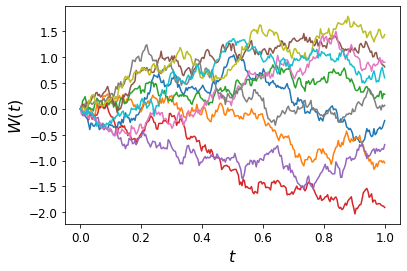

In [5]:
T = 1.
N = 2 ** 8
n_paths = 10

W = wienerprocess(T, N, n_paths)
t = np.linspace(0, T, N + 1)

plt.plot(t, W)
plt.xlabel(r"$t$")
plt.ylabel(r"$W(t)$");

# Geometric Brownian motion

Given a Wiener process $W_t$ the geometric Brownian motion (GBM) is given by

$$
S_t = S_0 \exp \left[\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t\right],
$$

where $\mu \in \mathbb{R}$ denotes the **drift**, and $\sigma > 0$ the **volatility** of the process. The former is used to model deterministic trends, while the latter is often used to model unpredictable events occurring during the motion. The example below shows the influence of the parameters on the GBM.

In the **Black-Scholes model**, the simplest and most widely used (continuous-time) financial model for valuing options, the GBM is used as an approximation for the price process of an underlying asset.

In [6]:
T = 1.
N = 2 ** 8
n_paths = 1

t = np.linspace(0, T, N + 1)
W = wienerprocess(T, N, n_paths)

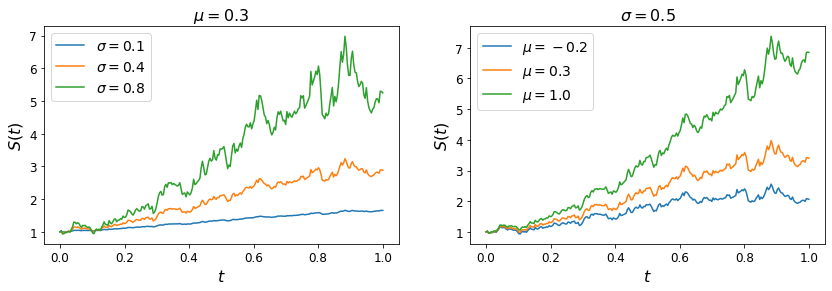

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 4))
for i, ax in enumerate(axs):
    s0 = 1
    if i == 0:
        mu = 0.3
        sigmas = [0.1, 0.4, 0.8]
        for sigma in sigmas:
            a = mu - sigma ** 2 / 2
            ex_sol = s0 * np.exp(a * t + sigma * W.T).T
            ax.plot(t, ex_sol, label=fr"$\sigma={sigma}$")
        ax.set_title(fr"$\mu = {mu}$", size=16)
    else:
        sigma = 0.5
        mus = [-0.2, 0.3, 1.0]
        for mu in mus:
            a = mu - sigma ** 2 / 2
            ex_sol = s0 * np.exp(a * t + sigma * W.T).T
            ax.plot(t, ex_sol, label=fr"$\mu={mu}$")  
        ax.set_title(fr"$\sigma = {sigma}$", size=16)
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$S(t)$")
    ax.legend();

## Euler-Maruyama method

The above introduced GBM is actually the solution of the stochastic differential equation (SDE)

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

with initial value $S_0 \in \mathbb{R}$. The **Euler-Maruyama method**  is a method for approximating the solution of a SDE. It is an extension of the Euler method for ordinary differential equations to stochastic differential equations. In our case, using the step size $\tau = T / N$ and the Wiener increments $\Delta W_n = W_{n+1} - W_n$, the procedure is given by

$$
S_{n+1} = S_n + \tau \mu S_n + \sigma S_n \Delta W_n,
$$
which can be **vectorized** by
$$
S_{n+1} = S_0 \prod_{k=0}^{n-1} \, (1 + \tau \mu + \sigma \Delta W_k).
$$

The figure below shows the approximation to the solution of the above SDE with drift $\mu = 0.3$, volatility $\sigma = 0.4$ and initial contion $S_0 = 1$ using the Euler-Maruyama method with different time steps $\tau = T/N$, namely for $N \in \{16, 64, 256\}$.

In [8]:
s0 = 100
mu = 0.3
sigma = 0.4
a = mu - sigma ** 2 / 2

ex_sol = s0 * np.exp(a * t + sigma * W.reshape(-1))

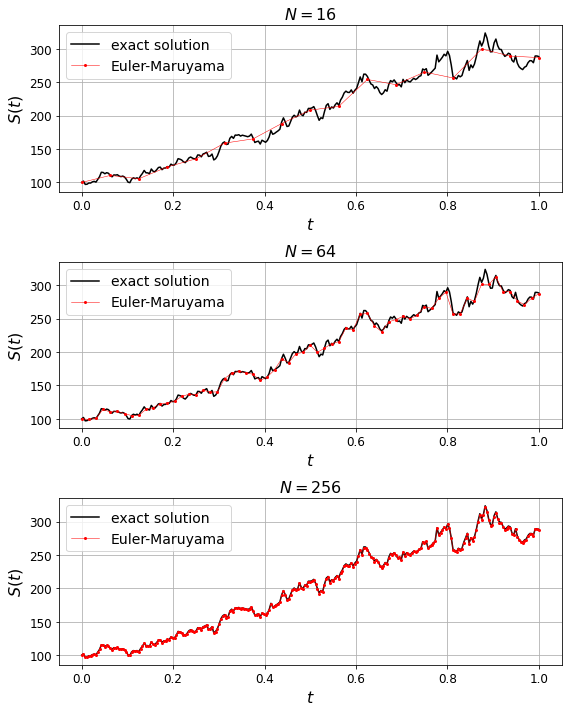

In [9]:
N_arr = 2 ** np.array([4, 6, 8])
fig, ax = plt.subplots(nrows=3, figsize=(8, 10))
S_dict ={}
for i in range(len(N_arr)):
    t_eval = np.arange(0, N+1, int(N / N_arr[i]))
    num_sol = eulerMaruyama(mu, sigma, s0, N_arr[i], T, W[t_eval], endpoint=False)
    S_dict.update({N_arr[i]: num_sol})
    ax[i].plot(t, ex_sol, "k", label="exact solution")
    t_ = np.linspace(0, T, num_sol.size)
    ax[i].plot(t_, num_sol, "ro-", lw=.5, markersize=2, label="Euler-Maruyama")
    ax[i].set_title(fr"$N = {N_arr[i]}$", size=16)
    ax[i].set_xlabel(r"$t$")
    ax[i].set_ylabel(r"$S(t)$")
    ax[i].legend()
    ax[i].grid()
    
plt.tight_layout()

The market price of the perpetual put option
\begin{equation}
        P_{\infty}(S) = (X - \bar{S}) (\frac{S}{\bar{S}})^{-\gamma} = \frac{X}{1+\gamma} (\frac{(1+\gamma) S}{\gamma S})^{-\gamma}. 
        \label{1.27}
    \end{equation}


 

In [101]:
def perpetual_put_option(s0,X,r,sigma):
    gamma = (2*r)/(sigma**2)
    p_inf = (X/(1+gamma)) * ( ((1+gamma)*s0) / (gamma*s0) )**(-gamma)
    return p_inf

In [102]:
s0 = 100
mu = 0.3
sigma = 0.4
strike_rate = np.asarray([0.2,0.4,0.6,0.8])
a = mu - sigma ** 2 / 2
ex_sol = s0 * np.exp(a * t + sigma * W.reshape(-1))
num_sol = S_dict[256]
putpreis_ex = np.zeros((len(X), len(ex_sol)))
for i in range (len(ex_sol)):
    X = ex_sol[i]*strike_rate
    for j in range(len(X)):
        putpreis_ex[j,i] = perpetual_put_option(ex_sol[i],X[j],mu, sigma)
putpreis_num = np.zeros((len(X), len(num_sol)))
for i in range (len(num_sol)):
    X = num_sol[i]*strike_rate
    for j in range(len(X)):
        putpreis_num[j,i] = perpetual_put_option(num_sol[i],X[j],mu, sigma)

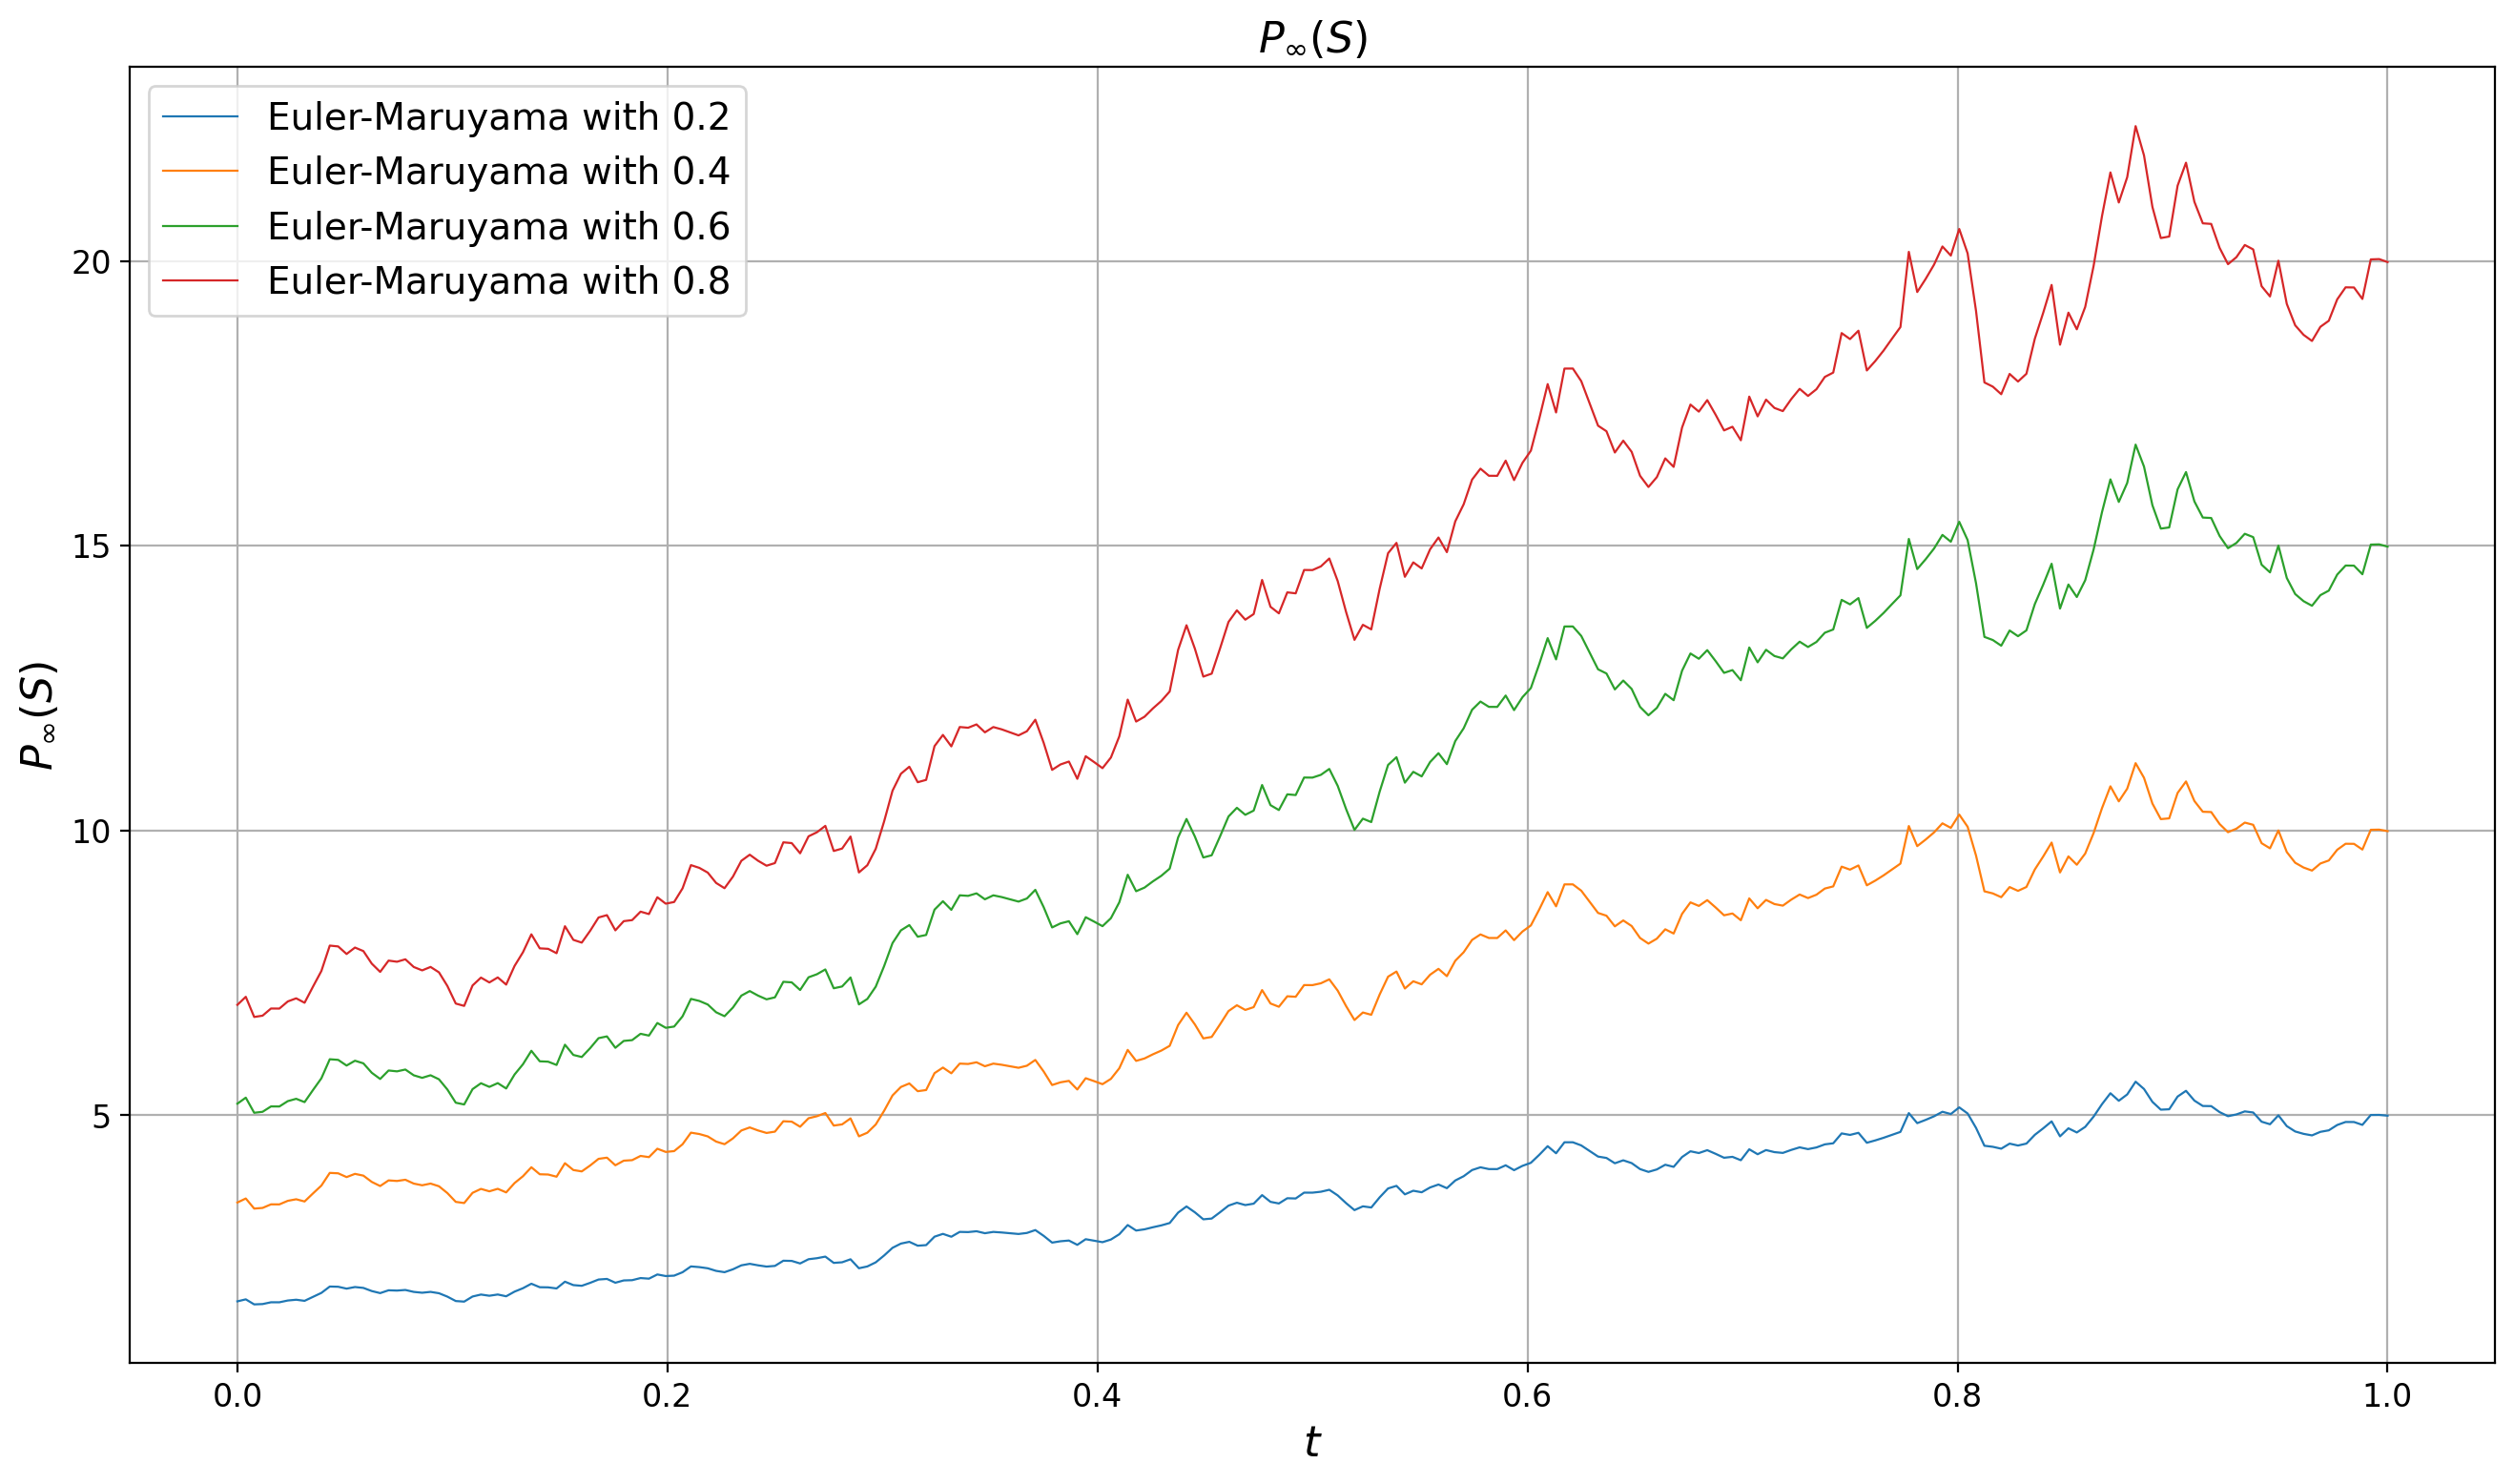

In [106]:
fig, ax = plt.subplots(dpi=200)
fig.set_size_inches(16, 9)
t_eval = np.arange(0, N+1, int(N / 256))
#ax.plot(t, putpreis_ex[i,:], "k", label="exact solution")
for i in range(len(strike_rate)):
    #ax.plot(t, putpreis_ex[i,:], "k", label=f"exact solution {strike_rate[i]}")
    ax.plot(t_, putpreis_num[i,:], "-", lw=.8, markersize=2, label=f"Euler-Maruyama with {strike_rate[i]}")
ax.set_title(r"$P_{\infty}(S)$", size=16)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$P_{\infty}(S)$")
ax.legend()
ax.grid()